<a href="https://colab.research.google.com/github/luyuzhe111/image-caption-match/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
os.chdir('/content/drive/MyDrive/kaggle/wikipedia')

In [ ]:
import pandas as pd
from tqdm import tqdm

# Import packages

In [ ]:
! pip install -q albumentations==0.4.6

     |████████████████████████████████| 117 kB 4.3 MB/s 
     |████████████████████████████████| 948 kB 30.2 MB/s 


In [ ]:
! pip install cairosvg

     |████████████████████████████████| 45 kB 1.6 MB/s 
     |████████████████████████████████| 88 kB 4.2 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89667 sha256=4e94fcc26a9f9da27ba0d83afea1f04d9b9fcebc48975285a8bc19e0ae499cf9
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [ ]:
! pip install transformers

     |████████████████████████████████| 3.3 MB 4.2 MB/s 
     |████████████████████████████████| 61 kB 514 kB/s 
     |████████████████████████████████| 895 kB 38.3 MB/s 
     |████████████████████████████████| 3.3 MB 37.3 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch-metric-learning

     |████████████████████████████████| 102 kB 4.5 MB/s 


In [ ]:
import glob
import gc
gc.enable()
import multiprocessing
import cv2
import copy
import time
import random
from PIL import Image
from PIL import ImageFile

import base64
import pickle

# fold
from sklearn.model_selection import StratifiedKFold

# For downloading images
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd
from numpy import asarray

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision


# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# For Image Models
# import timm

# For Transformer Models
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel, BertConfig

import torchvision.transforms as transforms

import warnings
warnings.filterwarnings("ignore")


# Load data

In [ ]:
# load data from input files
df_train = pd.read_feather('./train-subsample.feather')
df_valid = pd.read_feather('./valid-subsample.feather')
df_test = pd.read_feather('./test-set.feather')

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
lan_counter = Counter(df_train['language'])

In [ ]:
lans = [str(i) for i in list(lan_counter.keys())]
counts = [int(i) for i in list(lan_counter.values())]

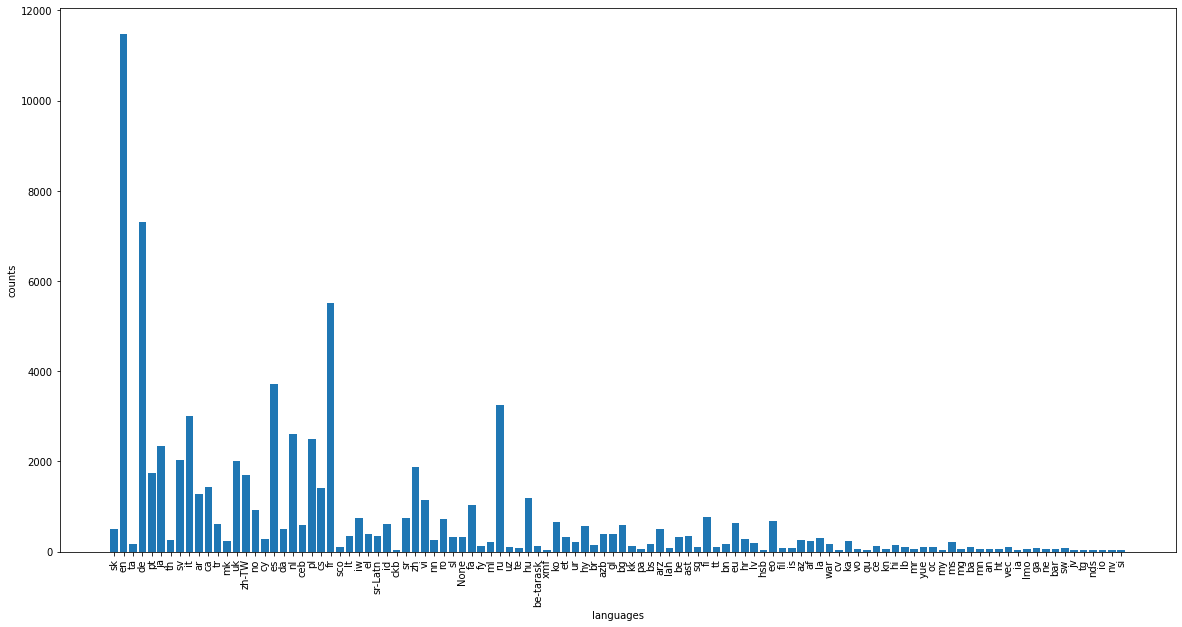

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(lans, counts)
plt.xticks(lans, lans, rotation='vertical')
plt.ylabel('counts')
plt.xlabel('languages')
plt.savefig('language_count.png', dpi=300)

In [ ]:
cap_counter = Counter([len(i) for i in df_train['caption_title_and_reference_description']])

In [ ]:
cap_lens = [int(i) for i in list(cap_counter.keys())]
cap_lens_count = [int(i) for i in list(cap_counter.values())]

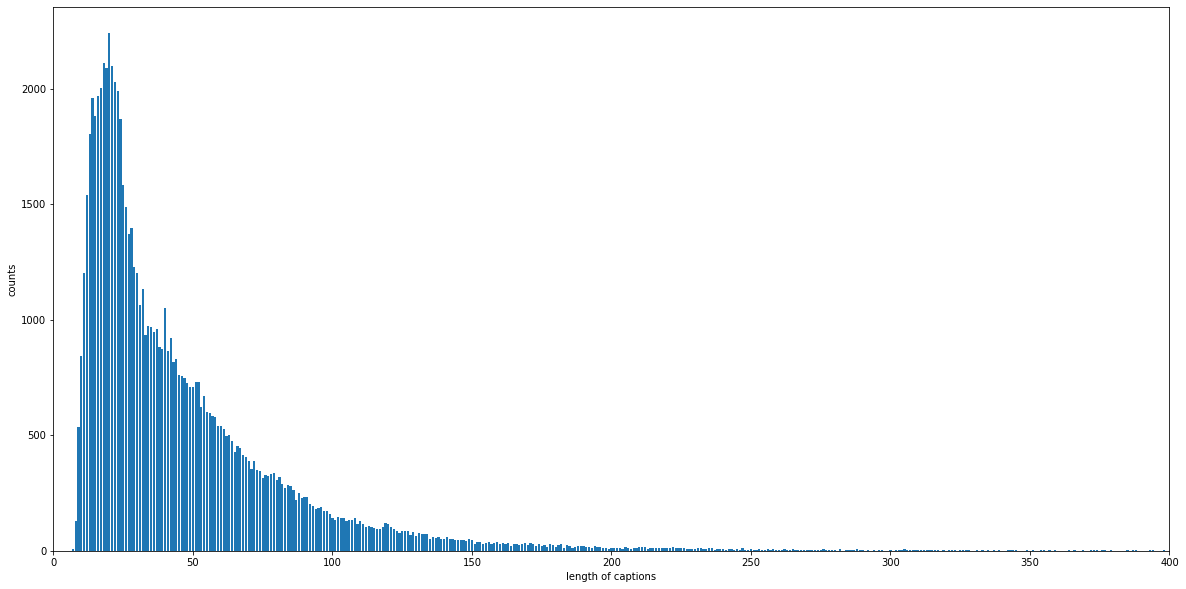

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(cap_lens, cap_lens_count)
plt.xlim([0, 400])
plt.ylabel('counts')
plt.xlabel('length of captions')
plt.savefig('caption_length_count.png', dpi=300)

In [ ]:
df_train.head(3)

,language,image_url,caption_title_and_reference_description,page_title,path
0,sk,http://upload.wikimedia.org/wikipedia/commons/...,Edubuntu </s> Edubuntu 7.04 - Gaim a napaľovanie,Edubuntu,./images/images0/sk/13737.jpg
1,en,https://upload.wikimedia.org/wikipedia/commons...,Lensfield Road </s>,Lensfield Road,./images/images4/en/95883.jpg
2,en,http://upload.wikimedia.org/wikipedia/commons/...,Argao </s> Old cannons of Argao,Argao,./images/images3/en/66896.jpg


In [ ]:
print(f'size of the train/val/test dataset: {len(df_train)}, {len(df_valid)}, {len(df_test)}')

size of the train/val/test dataset: 79342, 9918, 300


# Set up


## config

In [ ]:
def optimal_num_of_loader_workers():
    num_cpus = multiprocessing.cpu_count()
    num_gpus = torch.cuda.device_count()
    optimal_value = min(num_cpus, num_gpus*4) if num_gpus else num_cpus - 1
    return optimal_value

In [ ]:
CONFIG = {
    "seed": 2021,
    "epochs": 5,
    
    "img_size": 224,
    "embedding_size": 1024,
    "text_model_name": "xlm-roberta-base",
    "pool": 'gem-2',
    "freeze_image_model": False,
    "freeze_text_model": False,
    "normalize_embeddings": False, 
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "learning_rate": 1e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    'num_workers':4,
    
    "T_max": 500,
    "weight_decay": 1e-6,
    "max_length": 32,
    
    "n_accumulate": 1,
}

CONFIG["experiment"] = f"dim-{CONFIG['embedding_size']}_pool-{CONFIG['pool']}"
if CONFIG["normalize_embeddings"]:
  CONFIG["experiment"] = CONFIG["experiment"] + '_norm'
CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['text_model_name'])

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

# Dataset

In [ ]:
def load_img(dir):
  image = Image.open(dir)
  return image

In [ ]:
class WikipediaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, transforms=None):
        self.data = data.reset_index(drop=True)
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = load_img(self.data.at[index, "path"])
        if self.transforms:
          img = self.transforms(img)
        
        caption = self.data.at[index, "caption_title_and_reference_description"]
        caption = caption.replace("[SEP]", "</s>") # sep token for xlm-roberta
        inputs = self.tokenizer.encode_plus(
            caption,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length'
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
       
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'image': img,
        }

# Data Transforms

In [ ]:
data_transforms = {
    "train": transforms.Compose([   
        transforms.RandomHorizontalFlip(),                                      
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    
    "valid": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

# Dataloader

In [ ]:
train_dataset = WikipediaDataset(df_train, CONFIG["tokenizer"], CONFIG["max_length"], transforms=data_transforms["train"])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], num_workers=CONFIG['num_workers'], shuffle=True, pin_memory=True)

valid_dataset = WikipediaDataset(df_valid, CONFIG["tokenizer"], CONFIG["max_length"], transforms=data_transforms["valid"])
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], num_workers=CONFIG['num_workers'], shuffle=False, pin_memory=True)

test_dataset = WikipediaDataset(df_test, CONFIG["tokenizer"], CONFIG["max_length"], transforms=data_transforms["valid"])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], num_workers=CONFIG['num_workers'], shuffle=False, pin_memory=True)

# Image model

In [ ]:
from torchvision.models import resnet50

In [ ]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self, projector=[2048, 512, 64, 8], pool='gem-1'):
        super(ImageFeatureExtractor, self).__init__()
        model = resnet50(pretrained=True)
        modules = nn.ModuleList(model.children())[:-2]
        self.features = nn.Sequential(*modules)

        arch=[]
        for i in range(1,len(projector)):
            arch.append(nn.Linear(projector[i-1], projector[i]))
            if i!=len(projector)-1:
                arch.append(nn.ReLU())
        
        self.projector=nn.Sequential(*arch)
        self.pool = pool

    def forward(self, inputs):
        output = self.features(inputs)
        output = torch.flatten(output, start_dim=-2)
        if self.pool == 'gem-1':
          output = output.mean(-1)
        elif self.pool == 'gem-2':
          output = torch.pow((output ** 2).mean(-1), 1/2)
        elif self.pool == 'gem-inf':
          output = output.max(-1)[0]
        output = self.projector(output)
        return output

In [ ]:
projector = [2048, CONFIG['embedding_size']]
image_model = ImageFeatureExtractor(projector=projector, pool=CONFIG['pool']).cuda()
image_model.train()
if CONFIG['freeze_image_model']:
  print('freeze image encoder features')
  for name, p in image_model.named_parameters():
    if 'features' in name:
      p.requires_grad = False

# Text model

In [ ]:
class TextExtractorModel(nn.Module):
    def __init__(self, text_model, projector=[748, 96, 32]):
        super(TextExtractorModel, self).__init__()
        self.text_model = AutoModel.from_pretrained(text_model)

        arch=[]
        for i in range(1,len(projector)):
            arch.append(nn.Linear(projector[i-1], projector[i]))
            if i!=len(projector)-1:
                arch.append(nn.ReLU())
        
        self.projector=nn.Sequential(*arch)
        self.init_weights(self.projector)
        
    def init_weights(self, m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0)
            
    def forward(self, ids, mask):
        out = self.text_model(input_ids=ids, attention_mask=mask, output_hidden_states=False)[1]
        text_embeddings = self.projector(out)
        return text_embeddings

In [ ]:
projector=[768, CONFIG['embedding_size']]
text_model = TextExtractorModel(CONFIG['text_model_name'], projector=projector).cuda()
text_model.train()
if CONFIG['freeze_text_model']:
  print('freeze text encoder features')
  for name, p in text_model.named_parameters():
    if 'text_model' in name:
      p.requires_grad = False

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Optimizer

In [ ]:
optimizer = optim.Adam([
                {'params': image_model.parameters()},
                {'params': text_model.parameters()}
            ], lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'], betas=(0.9, 0.999), amsgrad=True)

# Loss function

In [ ]:
from pytorch_metric_learning import distances, losses, miners
loss_func = losses.TripletMarginLoss(distance=distances.LpDistance(normalize_embeddings=CONFIG["normalize_embeddings"]))
miner = miners.MultiSimilarityMiner()

# Training & Validation

In [ ]:
def train(epoch, image_model, text_model):
  losses = []
  image_model.train()
  text_model.train()
  for index, item in enumerate(tqdm(train_loader)):
    optimizer.zero_grad()

    # transformed image
    img = item['image'].cuda()
    
    # tokens that define the captions
    mask = item['mask'].cuda()
    ids = item['ids'].cuda()          
    
    # get encoded images; N x feature_dim (N = batch size)
    image_outputs = image_model(img)

    # get encoded captions; N x feature_dim
    text_outputs = text_model(ids, mask)

    embeddings = torch.cat((image_outputs, text_outputs), dim=0) # 2N x feature_dim

    batch_size = image_outputs.shape[0]
    labels = torch.arange(batch_size)
    labels = torch.cat([labels, labels], dim=0)

    hard_pairs = miner(embeddings, labels)
    loss = loss_func(embeddings, labels, hard_pairs)
    
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

  return np.array(losses).mean()

In [ ]:
def validate(epoch, image_model, text_model, model_dir):
  losses = []
  
  with torch.no_grad():
    image_model.eval()
    text_model.eval()
    for index, item in enumerate(tqdm(valid_loader)):
      img = item['image'].cuda()
      mask = item['mask'].cuda()
      ids = item['ids'].cuda()          
      
      image_outputs = image_model(img)
      text_outputs = text_model(ids, mask)

      embeddings = torch.cat((image_outputs, text_outputs), dim=0) # 2N x feature_dim
      batch_size = image_outputs.shape[0]
      labels = torch.arange(batch_size)
      labels = torch.cat([labels, labels], dim=0)

      hard_pairs = miner(embeddings, labels)
      loss = loss_func(embeddings, labels, hard_pairs)

      losses.append(loss.item())
    
    torch.save(image_model.state_dict(), f'{model_dir}/image_model_epoch{epoch}.pt') 
    torch.save(text_model.state_dict(), f'{model_dir}/text_model_epoch{epoch}.pt') 

  return np.array(losses).mean()

In [ ]:
train_losses = []
valid_losses = []
best_val_loss = 1000
best_epoch = 0
epochs = 10
exp_name = CONFIG['experiment']
model_dir = f'./checkpoints/{exp_name}'
os.makedirs(model_dir, exist_ok=True)

for epoch in range(epochs):
  train_loss = train(epoch, image_model, text_model)
  valid_loss = validate(epoch, image_model, text_model, model_dir)

  print(train_loss, valid_loss)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  if valid_loss < best_val_loss:
    print(f'loss has been decreased from {best_val_loss} to {valid_loss}')
    best_val_loss = valid_loss
    best_epoch = epoch

    torch.save(image_model.state_dict(), f'{model_dir}/best_image_model.pt') 
    torch.save(text_model.state_dict(), f'{model_dir}/best_text_model.pt')

df = pd.DataFrame()
df['epochs'] = [i for i in range(epochs)]
df['train_loss'] = train_losses
df['val_loss'] = valid_losses
df.to_csv(f'{model_dir}/logger.csv')

100%|██████████| 310/310 [01:03<00:00,  4.88it/s]


0.2783396970420595 0.3990547482044466
loss has been decreased from 1000 to 0.3990547482044466


100%|██████████| 310/310 [00:54<00:00,  5.70it/s]


0.136276232129744 0.3432222064464323
loss has been decreased from 0.3990547482044466 to 0.3432222064464323


100%|██████████| 310/310 [00:52<00:00,  5.94it/s]


0.12357714285232847 0.3072634062459392
loss has been decreased from 0.3432222064464323 to 0.3072634062459392


100%|██████████| 310/310 [00:51<00:00,  6.01it/s]


0.11666413700628665 0.2791270008971614
loss has been decreased from 0.3072634062459392 to 0.2791270008971614


100%|██████████| 310/310 [00:53<00:00,  5.80it/s]


0.11138389994720778 0.2524787601444029
loss has been decreased from 0.2791270008971614 to 0.2524787601444029


100%|██████████| 310/310 [01:00<00:00,  5.10it/s]


0.10724006131772072 0.2392002728677565
loss has been decreased from 0.2524787601444029 to 0.2392002728677565


100%|██████████| 310/310 [01:09<00:00,  4.47it/s]


0.10434448779410412 0.23038990641793897
loss has been decreased from 0.2392002728677565 to 0.23038990641793897


100%|██████████| 310/310 [01:25<00:00,  3.62it/s]


0.10242539566731261 0.21745871848637058
loss has been decreased from 0.23038990641793897 to 0.21745871848637058


100%|██████████| 310/310 [01:22<00:00,  3.76it/s]


0.10027391381802098 0.21241294347470807
loss has been decreased from 0.21745871848637058 to 0.21241294347470807


100%|██████████| 310/310 [01:23<00:00,  3.71it/s]


0.09899038927809846 0.20520761734054935
loss has been decreased from 0.21241294347470807 to 0.20520761734054935


In [ ]:
projector = [2048, CONFIG['embedding_size']]
best_image_model = ImageFeatureExtractor(projector=projector, pool=CONFIG['pool']).cuda()
projector=[768, CONFIG['embedding_size']]
best_text_model = TextExtractorModel(CONFIG['text_model_name'], projector=projector).cuda()

best_image_model.load_state_dict(torch.load(f'{model_dir}/best_image_model.pt'))
best_text_model.load_state_dict(torch.load(f'{model_dir}/best_text_model.pt'))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

# Test model

In [ ]:
from torch.nn.functional import normalize

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import top_k_accuracy_score

In [ ]:
test_captions = df_test['caption_title_and_reference_description']
text_model.eval()
test_caption_tokens = []
for caption in tqdm(test_captions):
  inputs = CONFIG["tokenizer"].encode_plus(
              caption,
              truncation=True,
              add_special_tokens=True,
              max_length=CONFIG["max_length"],
              padding='max_length'
  )
  ids = torch.tensor(inputs['input_ids'], dtype=torch.long).cuda().unsqueeze(0)
  mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).cuda().unsqueeze(0)
  text_features = best_text_model(ids, mask)
  if CONFIG["normalize_embeddings"]:
    text_features = normalize(best_text_model(ids, mask))
  else:
    text_features = best_text_model(ids, mask)
  text_features = text_features.cpu().detach().numpy()
  test_caption_tokens.append(text_features.squeeze())
test_caption_base = np.stack(test_caption_tokens, axis=1).T

In [ ]:
caption_retriever = NearestNeighbors(n_neighbors=5, p=2).fit(test_caption_base)

In [ ]:
relevant_k = 10

In [ ]:
best_image_model.eval()
preds = []
for index, item in enumerate(tqdm(test_loader)):
  img = item['image'].cuda()
  mask = item['mask'].cuda()
  ids = item['ids'].cuda()          
  
  if CONFIG["normalize_embeddings"]:
    image_outputs = normalize(best_image_model(img)).cpu().detach().numpy()
  else:
    image_outputs = best_image_model(img).cpu().detach().numpy()
  _, retrieved_ids = caption_retriever.kneighbors(image_outputs, n_neighbors=relevant_k)
  preds.extend(retrieved_ids)

In [ ]:
targets = list(range(len(preds)))

### Top1 Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score([pred[0] for pred in preds], targets)

### Topk Accuracy

In [ ]:
desired_k = 5

In [ ]:
count = 0
for i in range(len(preds)):
  true = targets[i]
  if true in preds[i][:desired_k]:
    count += 1

print(count / len(preds))